In [1]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera
from tqdm import tqdm
from load import get_btch
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
tqdm.get_lock().locks = []

# decleare data parameters
par_train = {'data_dir'       : '/data/LiftFly3D/openmonkey/OMS_Dataset', #mac/ubuntu path
             #'data_dir'       : r'\Users\NeLy\Desktop\OMS_Dataset\OMS_Dataset', #windows path
             'out_dir'        : 'out', 
             'train_subjects' : ["7"],
             'test_subjects'  : ["9"]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

In [2]:
# takes around a minute
train_2d, train_3d, train_keys = list(), list(), list()
for btch in par_train["train_subjects"]:
    Data, _ = get_btch(btch, par_train["data_dir"])
    for idx, (k,v) in enumerate(Data.items()):
        train_2d.append(Data[k]["points2d"])
        train_3d.append(Data[k]["points3d"])
        train_keys.append(k)

test_2d, test_3d, test_keys = list(), list(), list()
for btch in par_train["test_subjects"]:
    Data, _ = get_btch(btch, par_train["data_dir"])
    for idx, (k,v) in enumerate(Data.items()):
        test_2d.append(Data[k]["points2d"])
        test_3d.append(Data[k]["points3d"])
        test_keys.append(k)

train_2d, train_3d = np.stack(train_2d), np.stack(train_3d)
test_2d, test_3d = np.stack(test_2d), np.stack(test_3d)

#remove points with with large variance for easier training
good_ind = np.where((train_2d.reshape(train_2d.shape[0], -1)).std(axis=1) < 1000)[0]
train_2d = train_2d[good_ind]
train_3d = train_3d[good_ind]

# l2 normalization
train_2d /= np.linalg.norm(train_2d, axis=(-1,-2), keepdims=True)
test_2d /= np.linalg.norm(test_2d, axis=(-1,-2), keepdims=True)

/home/user/Desktop/lp3d_final/LiftPose3D/examples/openmonkey_object/load.py:110: RuntimeWarning: invalid value encountered in true_divide
  offset = (vec / curr_length) * (bone_length[idx] - curr_length)


In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

[main.py:233]:INFO:Saving pre-processed 2D data at /home/user/Desktop/lp3d_final/LiftPose3D/examples/openmonkey_object/out/stat_2d.pth.tar.
[main.py:252]:INFO:Saving pre-processed 3D data at /home/user/Desktop/lp3d_final/LiftPose3D/examples/openmonkey_object/out/stat_3d.pth.tar.
[main.py:279]:INFO:Starting training model.
[main.py:290]:DEBUG:
==================Options=================
[main.py:291]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/lp3d_final/LiftPose3D/examples/openmonkey_object/out',
    'drop_input': 0.0,
    'dropout': 0.5,
    'epochs': 2,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/lp3d_final/LiftPose3D/examples/openmonkey_object/out',
    'out_dir': '/home/user/Desktop/lp3d_final/LiftPose3D/examples/openmonkey_object/out',
    'predict': False,
    'p

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  0.87709|: 100%|██████████| 490/490 [00:06<00:00, 73.27it/s]
Epoch 001 | LR  0.00100 | Loss Test  0.40244 | Loss Train  0.52619|: 100%|██████████| 490/490 [00:06<00:00, 70.93it/s]


[main.py:376]:INFO:starting testing in path: out
[lift.py:44]:INFO:Training on the device: cuda:0
[lift.py:73]:INFO:total params: 4.27M
[lift.py:79]:INFO:loading ckpt from 'out/ckpt_best.pth.tar'
[lift.py:87]:INFO:ckpt loaded (epoch: 2 | err: 0.3820822812872141)
[lift.py:120]:INFO:Saving results: /home/user/Desktop/lp3d_final/LiftPose3D/examples/openmonkey_object/out/test_results.pth.tar


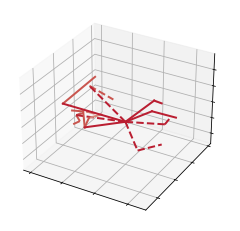

In [32]:
from liftpose.main import LiftPose3D
lp3d = LiftPose3D('param.yaml', **par_train)
lp3d.train(train_2d={'train': train_2d}, test_2d={'test': test_2d}, 
           train_3d={'train': train_3d}, test_3d={'test': test_3d},
           training_kwargs={"epochs":2})
lp3d.plot_pose_3d(plt.figure().add_subplot(111, projection='3d'), 0)